# KAN for Granger Causality
## Import Packages

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from synthetic import simulate_var
from torch.utils.data import DataLoader, TensorDataset
from copy import deepcopy
from models.ckan import cKAN
from models.model_helper import activation_helper
from tqdm import tqdm

In [2]:
# For GPU acceleration
device = torch.device('cpu')

# Set hyper-parameters
lag = 3
T = 1000
num_series = 5

## Generate Data

In [3]:
# Simulate data
X_np, beta, GC = simulate_var(p=num_series, T=T, lag=lag, sparsity=0.6)
X = torch.tensor(X_np[np.newaxis], dtype=torch.float32, device=device)  # add one new dimension for X

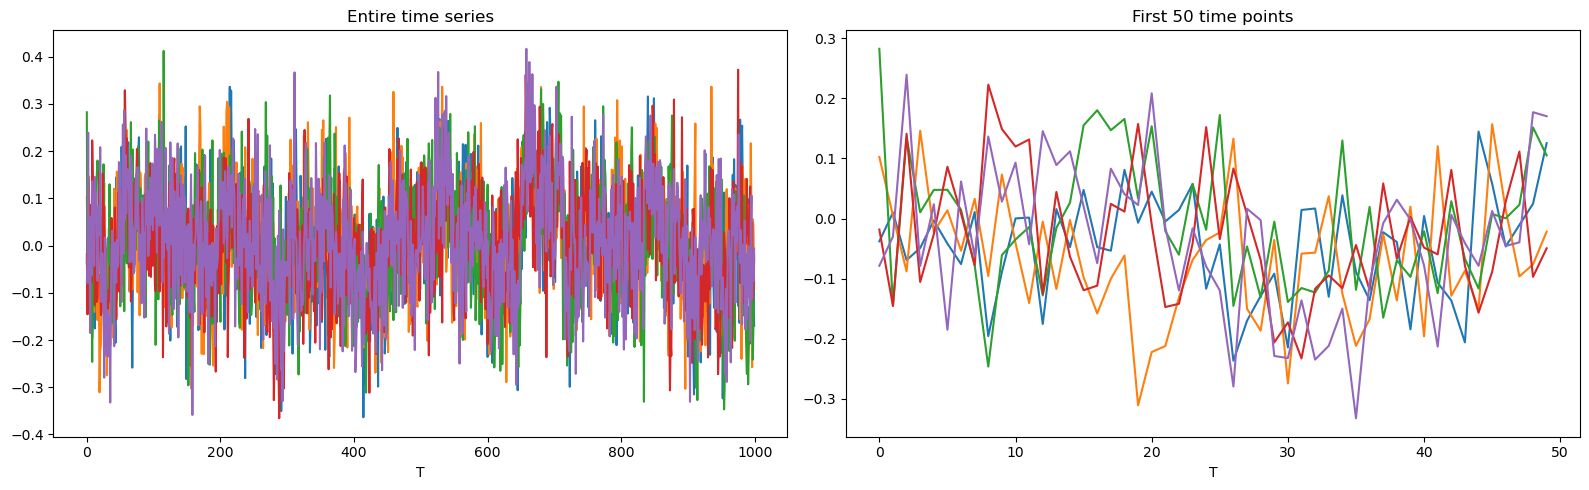

In [4]:
# Plot data
fig, axarr = plt.subplots(1, 2, figsize=(16, 5))
axarr[0].plot(X_np)
axarr[0].set_xlabel('T')
axarr[0].set_title('Entire time series')
axarr[1].plot(X_np[:50])
axarr[1].set_xlabel('T')
axarr[1].set_title('First 50 time points')
plt.tight_layout()
plt.show()

In [5]:
print(GC)

[[1 0 0 1 1]
 [1 1 0 1 0]
 [1 0 1 0 1]
 [1 1 0 1 0]
 [0 1 1 0 1]]


Now we see that the time series 1 is affected by time series 0,1,3. 

We set the value of time series 1 as the target and the rest as the input. The time lag is 3.

([], [])

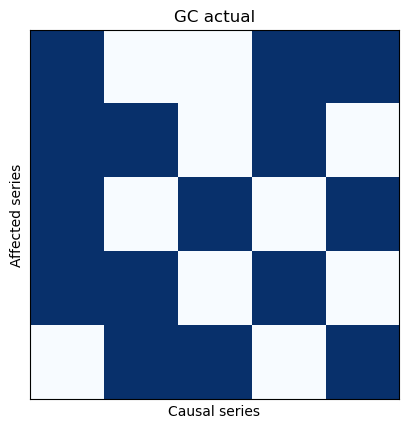

In [6]:
plt.imshow(GC, cmap='Blues')
plt.title('GC actual')
plt.ylabel('Affected series')
plt.xlabel('Causal series')
plt.xticks([])
plt.yticks([])

## Process the Data

In [7]:
# # Generate X-label
# t = torch.arange(Y.shape[-1])

# # create a dataframe
# df = pd.DataFrame({'Y': Y[0,:].detach().numpy()})[lag:]

# for i in range(num_series):
#     for j in range(lag):
#         df['ts{}_lag{}'.format(i, lag-j)] = X[0, :, i].detach().numpy()[j:-lag+j]

# df.head()

In [8]:
def rearrange_data(X):
    '''
    Rearrange the time series, to form a data with lags

    Input:
        X: tensor with shape (1, num_series, T)
    Output:
        array: tensor with shape (num_series * lag, T-lag)
    '''
    li = []
    for i in range(num_series):
        for j in range(lag):
            li.append(X[0, :, i].detach().numpy()[j:-lag+j])

    # transfer li to tensor
    array = torch.tensor(li, dtype=torch.float32, device=device)

    return array

In [9]:
array = rearrange_data(X).T
print(array.shape)

Y = X[:, :, 1][0, :T-lag]
print(Y.shape)


torch.Size([997, 15])
torch.Size([997])


/var/folders/yl/m5cgc23j1gbfcvxxglrgsk0w0000gn/T/ipykernel_37910/1129685958.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_9d63z49rj_/croot/pytorch_1681837279022/work/torch/csrc/utils/tensor_new.cpp:233.)
  array = torch.tensor(li, dtype=torch.float32, device=device)


In [10]:
trainloader = DataLoader(TensorDataset(array, Y), batch_size=32, shuffle=True)

## Build KAN Model

In [17]:
model = cKAN([num_series*lag, 128, 1])
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
criterion = nn.MSELoss(reduction='mean')

for epoch in range(10):
    # Train
    model.train()
    with tqdm(trainloader) as pbar:
        for i, (_, _) in enumerate(pbar):
            # images = images.view(-1, 28 * 28).to(device)
            optimizer.zero_grad()
            output = model(array)
            loss = criterion(output, Y)
            loss.backward()
            optimizer.step()
            # accuracy = (output.argmax(dim=1) == labels.to(device)).float().mean()
            pbar.set_postfix(loss=loss.item(), lr=optimizer.param_groups[0]['lr'])
    
    scheduler.step()
    print(
        f"Epoch {epoch + 1}"
    )

100%|██████████| 32/32 [00:04<00:00,  7.01it/s, loss=0.0143, lr=0.0001]


Epoch 1


100%|██████████| 32/32 [00:04<00:00,  7.39it/s, loss=0.0142, lr=8e-5]


Epoch 2


100%|██████████| 32/32 [00:04<00:00,  6.70it/s, loss=0.0142, lr=6.4e-5]


Epoch 3


100%|██████████| 32/32 [00:04<00:00,  7.26it/s, loss=0.0142, lr=5.12e-5]


Epoch 4


100%|██████████| 32/32 [00:03<00:00,  8.26it/s, loss=0.0142, lr=4.1e-5]


Epoch 5


100%|██████████| 32/32 [00:04<00:00,  7.58it/s, loss=0.0142, lr=3.28e-5]


Epoch 6


100%|██████████| 32/32 [00:03<00:00,  8.28it/s, loss=0.0142, lr=2.62e-5]


Epoch 7


100%|██████████| 32/32 [00:04<00:00,  7.86it/s, loss=0.0142, lr=2.1e-5]


Epoch 8


100%|██████████| 32/32 [00:04<00:00,  7.72it/s, loss=0.0142, lr=1.68e-5]


Epoch 9


100%|██████████| 32/32 [00:03<00:00,  8.04it/s, loss=0.0142, lr=1.34e-5]

Epoch 10


In [18]:
Y.shape

torch.Size([997])

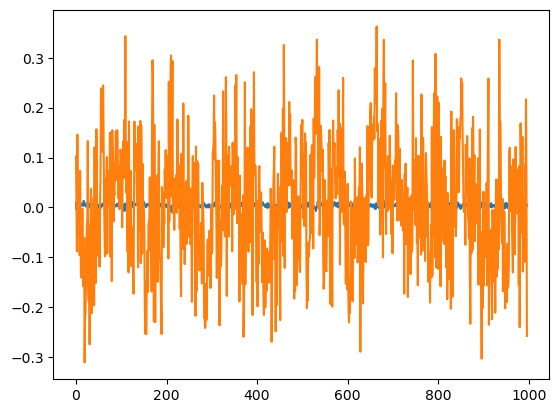

In [19]:
# plot output
plt.plot(output.detach().numpy(), label='Predicted')
plt.plot(Y.detach().numpy(), label='Actual')